# Homework 4

By Marvyn Bailly

In [6]:
import numpy as np
import scipy
from scipy.io import loadmat
from pywt import dwt2
import math
import matplotlib.pyplot as plt

#### Imports

Import Training Fun

In [7]:
trainingLables = loadmat("CP4_training_labels.mat")
trainingImages = loadmat("CP4_training_images.mat")

mData = trainingLables["training_labels"]
mDataList = [mData[i][0] for i in range(len(mData))]

mTrain = trainingImages["training_images"]
mTrainList = [mTrain[i] for i in range(len(mTrain))]
trainData = np.concatenate(mTrainList, axis=0)

#### Projecting onto Principal Components

Define Wavelet Transform Function

In [8]:
def generate_data(labels,data,test=True):
    if test:
        testLabalsArray = np.array([labels])
        getLabels = np.concatenate((testLabalsArray.T,data.T), axis=1)
        indices = list(np.where((getLabels[:,0] < 2))[0])
        testDataLabels = getLabels[indices,:]
        testData = testDataLabels[:,1:].T
        labels = list(testDataLabels[:,0])
        return labels,testData
    else:
        testLabalsArray = np.array([labels])
        getLabels = np.concatenate((testLabalsArray.T,data.T), axis=1)
        indices0 = list(np.where((getLabels[:,0] == 0))[0])
        testDataLabels0 = getLabels[indices0,:]
        testData0 = testDataLabels0[:,1:].T
        labels0 = list(testDataLabels0[:,0])
        
        indices1 = list(np.where((getLabels[:,0] == 1))[0])
        testDataLabels1 = getLabels[indices1,:]
        testData1 = testDataLabels1[:,1:].T
        labels1 =list(testDataLabels1[:,0])
        
        return labels0, testData0, labels1, testData1 

In [9]:
def rescale_linear(array, new_min, new_max):
    """Rescale an arrary linearly."""
    minimum, maximum = np.min(array), np.max(array)
    m = (new_max - new_min) / (maximum - minimum)
    b = new_min - m * minimum
    return m * array + b

In [10]:
def dc_wavelet(dc_file):
    m,n = dc_file.shape
    pxl = int(math.ceil(math.sqrt(m)))
    nw = m//4
    
    dcData = np.zeros((nw, n))
    for k in range(n):
        X = dc_file[:,k].reshape((pxl, pxl)).astype('float64')
        ca, (cH, cV, cd) = dwt2(X, 'haar') # only want horizontal and vertical
        cod_cH1 = np.abs(cH) # horizontal rescaled
        cod_cV1 = np.abs(cV) # vertical rescaled
        cod_cH1, cod_cV1 = rescale_linear(cod_cH1, 0, 1), rescale_linear(cod_cV1, 0, 1)
        cod_edge = cod_cH1 + cod_cV1
#         cod_edge = rescale_linear(cod_edge, 0, 1) # Rescale to [0, 1]
        cod_edge = np.reshape(cod_edge, (nw,))
        dcData[:,k] = cod_edge
    
    return dcData      

In [11]:
train_wave = dc_wavelet(trainData)

Compute the SVD

In [12]:
U, S, V = np.linalg.svd(train_wave, full_matrices=False)

In [13]:
print(U.shape,S.shape,V.shape)

(196, 196) (196,) (196, 30000)


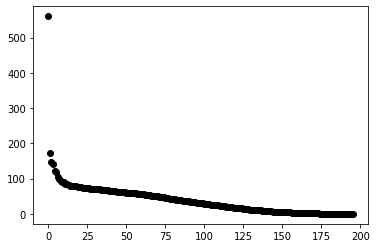

In [14]:
plt.plot(S,"ko",linewidth=2)

In [15]:
np.conjugate(V.T).shape

(30000, 196)

In [16]:
S_m = np.diag(S)


features = 15
A1 = features

princ_comp = S_m @ V
n_t = train_wave.shape[1]
train_wave = train_wave[0:features,0:n_t]

In [17]:
A2 = U[:,0:features]

Now we wish to seperate the 0's and the 1's

In [82]:
# cols = ["col_" + str(x) for x in range(1,features+1)]
# train_wave_df = pd.DataFrame(train_wave.T,columns=cols)
# labels_df = pd.DataFrame(mDataList, columns=["labels"])
# labels_train_df = pd.concat([labels_df,train_wave_df],axis=1)
# reduced0 = labels_train_df.loc[(labels_train_df['labels'] == 0)]
# reduced1 = labels_train_df.loc[(labels_train_df["labels"] == 1)]
# reduced_no_label0 = reduced0.loc[:,[x for x in reduced0.columns if x != "labels"]]
# train_wave_reduced0 = reduced_no_label0.to_numpy().T
# n0 = train_wave_reduced0.shape[1]
# reduced_no_label1 = reduced1.loc[:,[x for x in reduced1.columns if x != "labels"]]
# train_wave_reduced1 = reduced_no_label1.to_numpy().T
# n1 = train_wave_reduced1.shape[1]
# labels0 = reduced0["labels"].to_list()
# labels1 = reduced1["labels"].to_list()

In [18]:
labels0, train_wave_reduced0, labels1, train_wave_reduced1= generate_data(mDataList, train_wave,False)

Take the average of the sets

In [19]:
n0 = train_wave_reduced0.shape[1]
n1 = train_wave_reduced1.shape[1]

zeros = princ_comp[0:features, 0:n0]
ones = princ_comp[0:features, n0+1:n0+n1]

mean_train0 = np.mean(zeros, axis=1)
mean_train1 = np.mean(ones, axis=1)

Calculate variance within classes

In [20]:
Sw = 0
for i in range(n0):
    Sw += np.conjugate((np.array([zeros[:,i]]) - np.array([mean_train0])).T)@(np.array([zeros[:,i]]) - np.array([mean_train0]))
for j in range(n1):
    Sw += np.conjugate((np.array([ones[:,i]]) - np.array([mean_train1])).T)@(np.array([ones[:,i]]) - np.array([mean_train1]))
A3 = Sw
A3.shape

(15, 15)

Calculate variance between classes

In [224]:
Sb = np.outer(mean_train0 - mean_train1,mean_train0 - mean_train1)
A4 = Sb

Find the best projection line

In [92]:
D, V2 = scipy.linalg.eig(Sb,Sw)
lam = max(abs(D))
ind = np.argmax(abs(D))
w = V2[:,ind]
w /= np.linalg.norm(w,2)
A5 = w
A5

array([-4.57483177e-04, -3.91471956e-02, -2.36034309e-01,  4.00358825e-02,
       -9.91851300e-02,  4.47577468e-02, -2.87519311e-02, -1.11599144e-02,
        1.28985383e-01,  3.42183976e-02, -8.53284784e-01, -9.51599891e-02,
       -3.93541431e-01, -2.75509176e-02,  1.33295432e-01])

Project data onto w 

In [125]:
vzeros = np.conjugate(w.T)@zeros
vones = np.conjugate(w.T)@ones


Orient all the ones on the lower end and all the zeros on the higher end

In [126]:
if np.mean(vzeros) > np.mean(vones):
    w *= -1
    vzeros *= -1
    vones *= -1

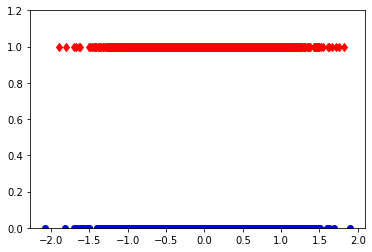

In [127]:
plt.plot(vzeros, np.zeros(len(vzeros)),"ob",linewidth=2)
plt.plot(vones, np.ones(len(vones)),"rd",linewidth=2)
plt.ylim([0, 1.2])
plt.show()

Find the Threshold

In [128]:
sortOnes = list(np.sort(vones))
sortZeros = list(np.sort(vzeros))

t1 = len(sortZeros) - 1
t2 = 1

while sortZeros[t1] > sortOnes[t2]:
    t1 -= 1
    t2 += 1
    
threshold = (sortZeros[t1] + sortOnes[t2])/2

In [129]:
A6 = threshold

-0.05973287614748804

#### Classify test data

In [103]:
testLables = loadmat("CP4_test_labels.mat")
testImages = loadmat("CP4_test_images.mat")

mDataTest = testLables["test_labels"]
mDataListTest = [mDataTest[i][0] for i in range(len(mDataTest))]

mTrainTest = testImages["test_images"]
mTrainListTest = [mTrainTest[i] for i in range(len(mTrainTest))]
testData = np.concatenate(mTrainListTest, axis=0)

get labels and labeless data

In [104]:
testDataLabels,testData = generate_data(mDataListTest,testData)


Wavelet Fun

In [110]:
testWave = dc_wavelet(testData)

In [140]:
testData[1].shape

(1062,)

In [153]:
testMat = np.conjugate(A2.T)@testWave
pval = np.conjugate(w.T)@testMat
A7 = np.array([pval])
testNum = testData[1].shape[0]

In [154]:
resVec = (pval > threshold)

err = abs(resVec - testDataLabels)
errNum = np.sum(err);
sucRate = 1 - errNum/testNum;

In [155]:
sucRate

-55.42843691148776